In [1]:
import logging
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/tmp/ipykernel_1524/26596093.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
%%R

suppressPackageStartupMessages({
    library(scran)
    library(scater)
    library(igraph)
    library(Seurat)
    library(cowplot)
    library(slingshot)
    library(dplyr)
    library(dynwrap)
    library(SingleCellExperiment)
    library(tradeSeq)
})
BiocParallel::register(BiocParallel::SerialParam())


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [4]:
%%R
dataset <- readRDS("mesoderm-development_loh (1).rds")
str(dataset)

List of 21
 $ id                   : chr "real/gold/mesoderm-development_loh"
 $ cell_ids             : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
 $ cell_info            :'data.frame':	504 obs. of  4 variables:
  ..$ cell_id     : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ Run         : chr [1:504] "SRR3952323" "SRR3952325" "SRR3952326" "SRR3952327" ...
  ..$ LibraryName : chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
  ..$ milestone_id: chr [1:504] "H7hESC" "H7hESC" "H7hESC" "H7hESC" ...
 $ source               : chr "real/gold"
 $ normalisation_info   :List of 3
  ..$ has_spike          : logi TRUE
  ..$ has_mito           : logi TRUE
  ..$ normalisation_steps: tibble [6 × 3] (S3: tbl_df/tbl/data.frame)
  .. ..$ type     : chr [1:6] "original" "cell_quality_filtering" "feature_expression_filtering" "normalisation" ...
  .. ..$ nfeatures: int [1:6] 58480 58480 36347 36347 8772 8772
  .. ..$ ncells   : int [1:6] 651 504 504

In [4]:
%%R
raw_counts <- dataset$counts

In [5]:
%%R
dim(counts)

NULL


In addition: Warning messages:
1: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates
2: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates
3: In (function (x, sizes, min.mean = NULL, positive = FALSE, scaling = NULL)  :
  encountered non-positive size factor estimates
4: In (function (to_check, X, clust_centers, clust_info, dtype, nn,  :
  detected tied distances to neighbors, see ?'BiocNeighbors-ties'


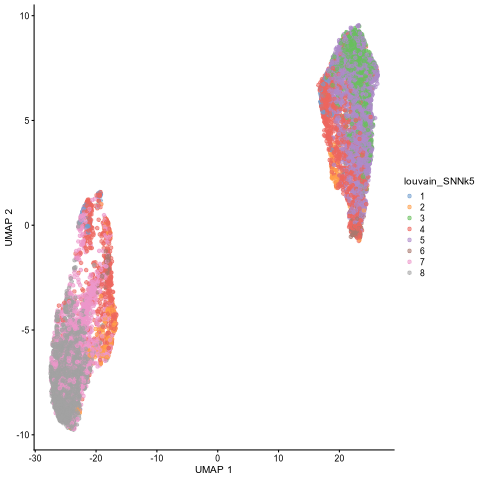

In [6]:
%%R
data <- SingleCellExperiment(assays = list(counts = raw_counts))
data <- computeSumFactors(data, sizes = c(20, 40, 60, 80))
data <- logNormCounts(data)
var.fit <- modelGeneVar(data)
top.hvgs <- getTopHVGs(var.fit, n = 2000)
data <- runPCA(data, subset_row = top.hvgs)
g <- buildSNNGraph(data, k = 5, use.dimred = "PCA")
data$louvain_SNNk5 <- factor(igraph::cluster_louvain(g)$membership)
data <- runUMAP(data, dimred = "PCA", n_dimred = 50, ncomponents = 2, spread = 2, min_dist = 0.1, n_neighbors = 10, metric = "cosine")

plotReducedDim(data, dimred = "UMAP", colour_by = "louvain_SNNk5")

In [7]:
%%R
dimred <- as.matrix(reducedDim(data, type = "UMAP"))
clustering <- as.numeric(data$louvain_SNNk5)
counts <- as.matrix(counts(data)[top.hvgs, ])

In [8]:
%%R
set.seed(1)
lineages <- getLineages(data = dimred, clusterLabels = clustering)

lineages

class: PseudotimeOrdering 
dim: 8772 3 
metadata(3): lineages mst slingParams
pathStats(2): pseudotime weights
cellnames(8772): COL3A1 DKK4 ... AC073257.2 RP1-28C20.1
cellData names(2): reducedDim clusterLabels
pathnames(3): Lineage1 Lineage2 Lineage3
pathData names(0):


In [9]:
%%R
class(lineages)

[1] "PseudotimeOrdering"
attr(,"package")
[1] "TrajectoryUtils"


In [10]:
# %%R
# slingshot_data <- slingshot(dimred, clusterLabels = clustering)

In [11]:
# %%R
# lineages <- slingLineages(slingshot_data)


In [12]:
# %%R
# lineages <- as.matrix(lineages)
# lineages <- do.call(rbind, lapply(lineages, function(x) {
#   as.matrix(x)  # Convert each lineage path to a matrix if it's not already
# }))

Error in as.vector(x, mode = "numeric") : 
  no method for coercing this S4 class to a vector


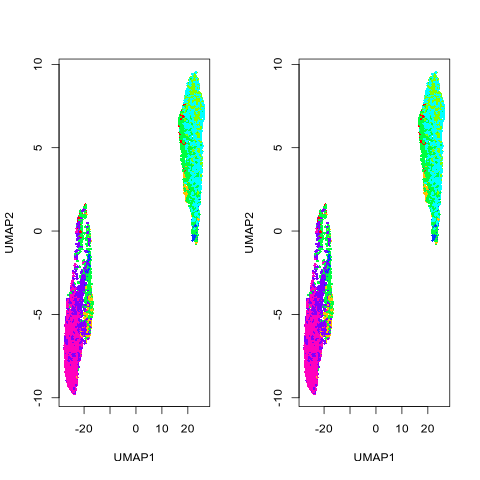

RInterpreterError: Failed to parse and evaluate line 'pal <- rainbow(length(unique(clustering)))\npar(mfrow = c(1, 2))\nplot(dimred[, 1:2], col = pal[clustering], cex = 0.5, pch = 16)\nfor (i in levels(clustering)) {\n    text(mean(dimred[clustering == i, 1]), mean(dimred[clustering == i, 2]), labels = i, font = 2)\n}\nplot(dimred[, 1:2], col = pal[clustering], cex = 0.5, pch = 16)\n# lines(SlingshotDataSet(slingshot_data), lwd = 3, col = "black")\nlines(lineages, lwd = 3, col = "black")\n'.
R error message: 'Error in as.vector(x, mode = "numeric") : \n  no method for coercing this S4 class to a vector'

In [13]:
%%R
pal <- rainbow(length(unique(clustering)))
par(mfrow = c(1, 2))
plot(dimred[, 1:2], col = pal[clustering], cex = 0.5, pch = 16)
for (i in levels(clustering)) {
    text(mean(dimred[clustering == i, 1]), mean(dimred[clustering == i, 2]), labels = i, font = 2)
}
plot(dimred[, 1:2], col = pal[clustering], cex = 0.5, pch = 16)
# lines(SlingshotDataSet(slingshot_data), lwd = 3, col = "black")
lines(lineages, lwd = 3, col = "black")

In [15]:
%%R
curves <- getCurves(lineages, approx_points = 300, thresh = 0.01, stretch = 0.8, allow.breaks = FALSE, shrink = 0.99)
curves

class: PseudotimeOrdering 
dim: 8772 3 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(8772): COL3A1 DKK4 ... AC073257.2 RP1-28C20.1
cellData names(2): reducedDim clusterLabels
pathnames(3): Lineage1 Lineage2 Lineage3
pathData names(0):


Error in as.vector(x, mode = "numeric") : 
  no method for coercing this S4 class to a vector


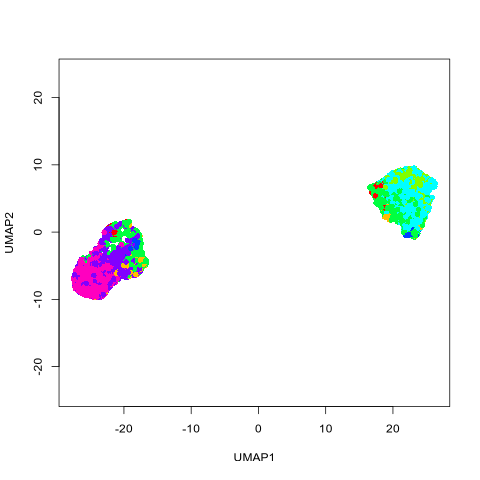

RInterpreterError: Failed to parse and evaluate line 'plot(dimred, col = pal[clustering], asp = 1, pch = 16)\nlines(curves, lwd = 3, col = "black")\n'.
R error message: 'Error in as.vector(x, mode = "numeric") : \n  no method for coercing this S4 class to a vector'

In [16]:
%%R
plot(dimred, col = pal[clustering], asp = 1, pch = 16)
lines(curves, lwd = 3, col = "black")

In [17]:
%%R
filt_counts <- counts[rowSums(counts > 5) > ncol(counts)/100, ]
dim(filt_counts)

[1]  246 8772


  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01m 39s       |++                                                | 2 % ~01m 22s       |++                                                | 4 % ~02m 02s       |+++                                               | 5 % ~01m 47s       |++++                                              | 6 % ~01m 34s       |++++                                              | 7 % ~01m 26s       |+++++                                             | 9 % ~01m 22s       |+++++                                             | 10% ~01m 20s       |++++++                                            | 11% ~01m 16s       |+++++++                                           | 12% ~01m 16s       |+++++++                                           | 13% ~01m 14s       |++++++++                                          | 15% ~01m 14s       |++++++++                                          | 16% ~01m 

TMM normalization failed. Will use unnormalized library sizesas offset.

Some library sizes are zero. Offsetting these to 1.



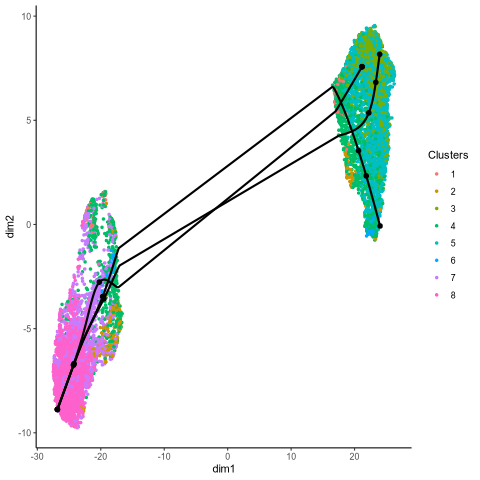

In [18]:
%%R
sce <- fitGAM(counts = as.matrix(filt_counts), sds = curves)
plotGeneCount(curves, filt_counts, clusters = clustering, models = sce)

In [19]:
%%R
library(dplyr)
plot_differential_expression <- function(feature_id) {
    feature_id <- pseudotime_association %>% filter(pvalue < 0.05) %>% top_n(1, -waldStat) %>% pull(feature_id)
    cowplot::plot_grid(plotGeneCount(curves, filt_counts, gene = feature_id[1], clusters = clustering, models = sce) + ggplot2::theme(legend.position = "none"), 
        plotSmoothers(sce, as.matrix(counts), gene = feature_id[1]))
}

In [20]:
%%R
pseudotime_association <- associationTest(sce)
pseudotime_association$fdr <- p.adjust(pseudotime_association$pvalue, method = "fdr")
pseudotime_association <- pseudotime_association[order(pseudotime_association$pvalue), ]
pseudotime_association$feature_id <- rownames(pseudotime_association)

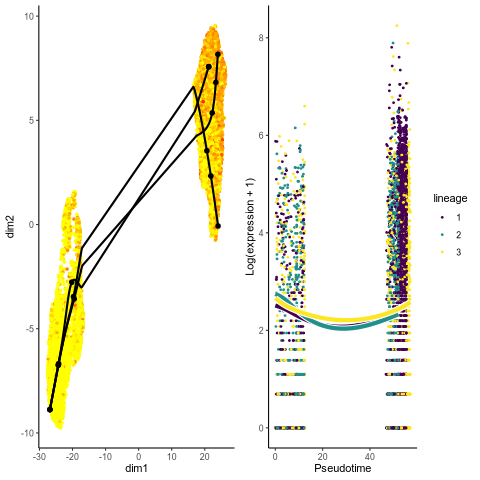

In [21]:
%%R
feature_id <- pseudotime_association %>% filter(pvalue < 0.05) %>% top_n(1, -waldStat) %>% pull(feature_id)
plot_differential_expression(feature_id)

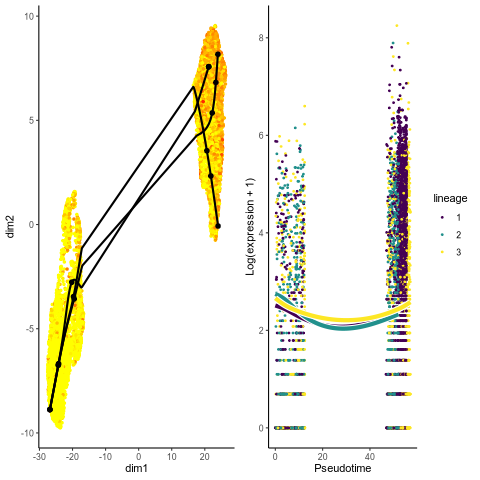

In [22]:
%%R
pseudotime_start_end_association <- startVsEndTest(sce, pseudotimeValues = c(0, 1))
pseudotime_start_end_association$feature_id <- rownames(pseudotime_start_end_association)

feature_id <- pseudotime_start_end_association %>% filter(pvalue < 0.05) %>% top_n(1, waldStat) %>% pull(feature_id)

plot_differential_expression(feature_id)

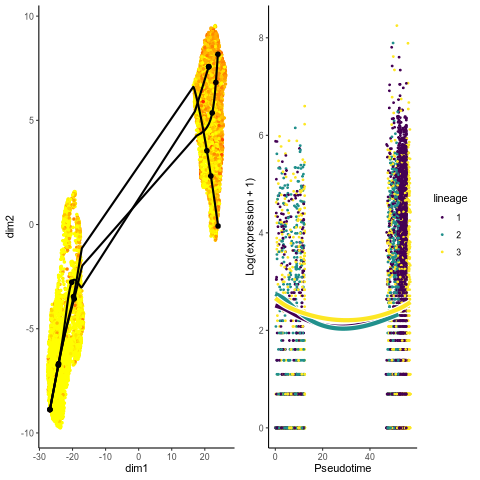

In [23]:
%%R
different_end_association <- diffEndTest(sce)
different_end_association$feature_id <- rownames(different_end_association)
feature_id <- different_end_association %>% filter(pvalue < 0.05) %>% arrange(desc(waldStat)) %>% dplyr::slice(1) %>% pull(feature_id)
plot_differential_expression(feature_id)

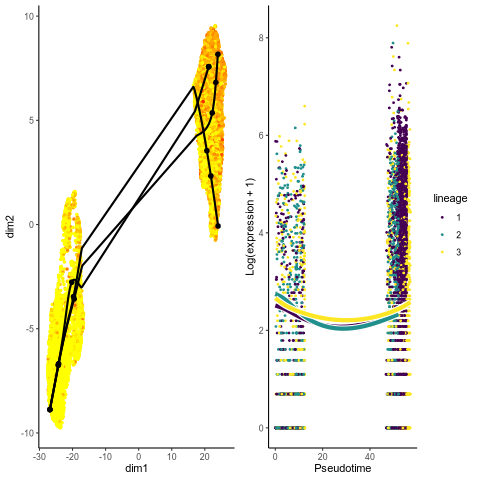

In [24]:
%%R
branch_point_association <- earlyDETest(sce)
branch_point_association$feature_id <- rownames(branch_point_association)
feature_id <- branch_point_association %>% filter(pvalue < 0.05) %>% arrange(desc(waldStat)) %>% dplyr::slice(1) %>% pull(feature_id)
plot_differential_expression(feature_id)